In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions

from Bio.PDB.PDBParser import PDBParser
sys.path.insert(0, '/Users/weilu/Research/opt_server/')
from pyCodeLib import *
%matplotlib inline
plt.rcParams['figure.figsize'] = np.array([10,6.180])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# data = pd.read_csv("/Users/weilu/Research/database/info_interaction_cutoff65_complete.csv", index_col=0)
data = pd.read_csv("/Users/weilu/Research/database/para_anti_para_with_six_letter_code.csv", index_col=0)

In [3]:
data.shape

(746520, 19)

In [4]:
similar_size_protein_list = data["Protein"].value_counts().reset_index().query("Protein > 50 and Protein < 400")["index"].to_list()
data_selected = data.query("Protein in @similar_size_protein_list").reset_index(drop=True)


In [5]:
data_selected.shape

(461632, 19)

In [29]:
len(similar_size_protein_list)

3252

In [14]:
tiny = data.sample(10)

In [6]:
a = data_selected.groupby(["Res1_1", "Res1_2", "Res2_1", "Res2_2", "Direction"])["Protein"].count().reset_index().sort_values("Protein")

In [7]:
a

,Res1_1,Res1_2,Res2_1,Res2_2,Direction,Protein
20277,LEU,TYR,GLY,ILE,parallel,1
9381,GLU,TRP,PRO,CYS,parallel,1
9387,GLU,TRP,TRP,PHE,anti,1
9389,GLU,TRP,TYR,GLY,anti,1
9390,GLU,TRP,TYR,GLY,parallel,1
...,...,...,...,...,...,...
13796,ILE,GLY,ILE,GLY,parallel,660
31922,THR,GLY,THR,GLY,parallel,701
34821,TRP,TRP,PRO,ARG,anti,771
23804,PHE,ALA,PHE,PHE,anti,892


In [8]:
a.query("Res1_1=='GLY' and Res1_2=='GLY' and Res2_1=='GLY' and Res2_2=='GLY'")

,Res1_1,Res1_2,Res2_1,Res2_2,Direction,Protein
10305,GLY,GLY,GLY,GLY,anti,83
10306,GLY,GLY,GLY,GLY,parallel,895


In [81]:
a.shape

(48267, 6)

In [69]:
a.query("Protein > 100").shape

(1402, 6)

In [70]:
a.query("Protein > 200").shape

(316, 6)

In [71]:
a.query("Protein > 500").shape

(37, 6)

In [9]:
from Bio.PDB.Polypeptide import one_to_index
from Bio.PDB.Polypeptide import three_to_index

def encode_resName(data):
    # if anti-parallel, the order by reading from res2_2 to res2_1
    if data["Direction"] == "anti":
        res2 = three_to_index(data["Res2_2"])*20 + three_to_index(data["Res2_1"])
        data["Res2_letter"] = data["Res2_2"] + "_" + data["Res2_1"]
    elif data["Direction"] == "parallel":
        res2 = three_to_index(data["Res2_1"])*20 + three_to_index(data["Res2_2"])
        data["Res2_letter"] = data["Res2_1"] + "_" + data["Res2_2"]
    res1 = three_to_index(data["Res1_1"])*20 + three_to_index(data["Res1_2"])
    data["Res1_letter"] = data["Res1_1"] + "_" + data["Res1_2"]
    # if res2 index is smaller than res1, We will swtich the index. to ensure res1 is less than res2.
    if res2 < res1:
        data["Res1"] = res2
        data["Res2"] = res1
    else:
        data["Res1"] = res1
        data["Res2"] = res2
    return data

In [10]:
a = a.apply(encode_resName, axis=1)

In [11]:
a

,Res1_1,Res1_2,Res2_1,Res2_2,Direction,Protein,Res2_letter,Res1_letter,Res1,Res2
20277,LEU,TYR,GLY,ILE,parallel,1,GLY_ILE,LEU_TYR,107,199
9381,GLU,TRP,PRO,CYS,parallel,1,PRO_CYS,GLU_TRP,78,241
9387,GLU,TRP,TRP,PHE,anti,1,PHE_TRP,GLU_TRP,78,98
9389,GLU,TRP,TYR,GLY,anti,1,GLY_TYR,GLU_TRP,78,119
9390,GLU,TRP,TYR,GLY,parallel,1,TYR_GLY,GLU_TRP,78,385
...,...,...,...,...,...,...,...,...,...,...
13796,ILE,GLY,ILE,GLY,parallel,660,ILE_GLY,ILE_GLY,145,145
31922,THR,GLY,THR,GLY,parallel,701,THR_GLY,THR_GLY,325,325
34821,TRP,TRP,PRO,ARG,anti,771,ARG_PRO,TRP_TRP,292,378
23804,PHE,ALA,PHE,PHE,anti,892,PHE_PHE,PHE_ALA,80,84


## b consider the symmetry between i, j.

In [12]:
b = a.groupby(["Res1", "Res2", "Direction"])["Protein"].sum().reset_index()
b

,Res1,Res2,Direction,Protein
0,0,0,anti,116
1,0,0,parallel,645
2,0,1,anti,13
3,0,1,parallel,22
4,0,2,parallel,6
...,...,...,...,...
31220,395,399,parallel,1
31221,396,396,anti,1
31222,396,397,anti,5
31223,396,398,anti,14


In [13]:
b.query("Protein > 10").shape

(8818, 4)

In [14]:
b.query("Protein > 100").shape

(654, 4)

In [15]:
b.query("Protein > 200").shape

(225, 4)

In [46]:
chosen = b.sort_values("Protein").tail(700).reset_index(drop=True)

In [47]:
chosen["interaction_index"] = chosen["Direction"] + "_" + chosen["Res1"].astype(str) + "_" + chosen["Res2"].astype(str)

In [49]:
chosen.to_csv("/Users/weilu/Research/data/interaction_index_jul12.csv")

In [137]:
b_cutoff_unique = pd.read_csv("/Users/weilu/Research/data/interaction_index_jul12.csv", index_col=0)

interaction_index_dic = {}
c = 0
for index in b_cutoff_unique["interaction_index"].to_list():
    interaction_index_dic[index] = c
    c += 1

In [32]:
chosen.groupby("Direction")["Protein"].count()

Direction
anti        436
parallel    164
Name: Protein, dtype: int64

In [140]:
b.query("Protein > 200")["Protein"].sum()

164150

In [167]:
b_cutoff_unique

,Res1,Res2,Direction,Protein,interaction_index
0,107,109,parallel,97,parallel_107_109
1,322,395,parallel,97,parallel_322_395
2,85,150,anti,97,anti_85_150
3,70,331,anti,97,anti_70_331
4,9,189,parallel,97,parallel_9_189
...,...,...,...,...,...
695,325,325,parallel,701,parallel_325_325
696,0,105,parallel,740,parallel_0_105
697,292,378,anti,771,anti_292_378
698,105,105,parallel,895,parallel_105_105


In [258]:
def encode_four_body_index(res1_1, res1_2, res2_1, res2_2, direction):
    # if anti-parallel, the order by reading from res2_2 to res2_1
    if direction == "anti":
        res2 = three_to_index(res2_2)*20 + three_to_index(res2_1)
        Res2_letter = res2_2 + "_" + res2_1
    elif direction == "parallel":
        res2 = three_to_index(res2_1)*20 + three_to_index(res2_2)
        Res2_letter = res2_1 + "_" + res2_2
    res1 = three_to_index(res1_1)*20 + three_to_index(res1_2)
    Res1_letter = res1_1 + "_" + res1_2
    # if res2 index is smaller than res1, We will swtich the index. to ensure res1 is less than res2.
    if res2 < res1:
        return res2, res1, Res1_letter, Res2_letter
    else:
        return res1, res2, Res1_letter, Res2_letter

b_cutoff_unique = pd.read_csv("/Users/weilu/Research/data/interaction_index_jul12.csv", index_col=0)

interaction_index_dic = {}
c = 0
for index in b_cutoff_unique["interaction_index"].to_list():
    interaction_index_dic[index] = c
    c += 1

def get_interaction_index_from_four_residues_v3(res1_1, res1_2, res2_1, res2_2, direction, interaction_index_dic=interaction_index_dic):
    res1, res2, Res1_letter, Res2_letter = encode_four_body_index(res1_1, res1_2, res2_1, res2_2, direction)
    try:
        index = interaction_index_dic[f"{direction}_{res1}_{res2}"]
    except:
        index = max(interaction_index_dic.values()) + 1
    return index


def encode_resName(data):
    # if anti-parallel, the order by reading from res2_2 to res2_1
    res1_1 = data["Res1_1"]
    res1_2 = data["Res1_2"]
    res2_1 = data["Res2_1"]
    res2_2 = data["Res2_2"]
    direction = data["Direction"]
    res1, res2, Res1_letter, Res2_letter = encode_four_body_index(res1_1, res1_2, res2_1, res2_2, direction)
    data["Res1"] = res1
    data["Res1_letter"] = Res1_letter
    data["Res2"] = res2
    data["Res2_letter"] = Res2_letter
    return data

In [259]:
get_interaction_index_from_four_residues_v3("GLY", "GLY", "GLY", "GLY", "anti")

700

In [161]:
get_interaction_index_from_four_residues_v3("GLY", "GLY", "GLY", "GLY", "parallel")

698

In [290]:
def compute_gxxxg_energy(structure, gamma, sequence=None, get_interaction_index=get_interaction_index_from_four_residues_v3):
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    if sequence is None:
        sequence = get_sequence_from_structure(structure)

    min_seq_sep = 10
    r_min = 2.0
    r_max = 6.5
    kappa = 5
    n_parameters = 1 + max(interaction_index_dic.values()) + 1
    info_list = []
    get_distance_between_two_residues = get_interaction_distance_com
    phi_gxxxg_well = np.zeros(n_parameters)

    e_gxxxg = 0.0
    e_gxxxg_parallel = 0.0
    e_gxxxg_anti_parallel = 0.0

    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)

            for shift_to_res2_2, direction in zip([-4, 4], ["anti", "parallel"]):
                res1_2_globalindex = res1globalindex + 4
                res1_2 = get_res_by_globalindex(res_list, res1_2_globalindex, res1chain)
                # for shift_to_res2_2 in [-4, 4]:

                # consider parallel, and anti-parallel.
                res2_2_globalindex = res2globalindex + shift_to_res2_2
                res2_2 = get_res_by_globalindex(res_list, res2_2_globalindex, res2chain)
                if res1_2 == -1 or res2_2 == -1:
                    continue
                if direction == "parallel":
                    sep = res1globalindex - res2globalindex
                elif direction == "anti":
                    sep = res1globalindex - res2_2_globalindex
                if sep >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
                    rij = get_distance_between_two_residues(res1, res2)

                    rij_2 = get_distance_between_two_residues(res1_2, res2_2)
    #                 if rij_2 > (r_max+2):
    #                     continue
                    resName_1_1 = one_to_three(sequence[res1globalindex])
                    resName_1_2 = one_to_three(sequence[res1_2_globalindex])
                    resName_2_1 = one_to_three(sequence[res2globalindex])
                    resName_2_2 = one_to_three(sequence[res2_2_globalindex])
                    # interaction_index = get_interaction_index_from_four_residues(res1.resname, res1_2.resname, res2.resname, res2_2.resname)
                    # interaction_index = get_interaction_index_from_four_residues_v2(resName_1_1, resName_1_2, resName_2_1, resName_2_2)
                    interaction_index = get_interaction_index(resName_1_1, resName_1_2, resName_2_1, resName_2_2, direction)
                    phi_ = interaction_well(rij, r_min, r_max, kappa) * interaction_well(rij_2, r_min, r_max, kappa)
                    # phi_gxxxg_well[interaction_index] += phi_
                    if shift_to_res2_2 == -4:
                        e_gxxxg_anti_parallel += gamma[interaction_index] * phi_
                    else:
                        e_gxxxg_parallel += gamma[interaction_index] * phi_
                    # print(res1globalindex, res2globalindex, resName_1_1, resName_2_1, gamma[interaction_index], phi_)
    e_gxxxg = e_gxxxg_parallel + e_gxxxg_anti_parallel
    return e_gxxxg

In [176]:
# fileLocation = "/Users/weilu/Research/server/jul_week1_2020/decoyN2000_gxxxg_shuffle_optimization/optimization_decoyN2000/gammas/filtered_protein_list_phi_gxxxg_v2_well126_gamma"
# gamma = np.loadtxt(fileLocation)
fileLocation = "/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/gxxxg_701.dat"
gamma = np.loadtxt(fileLocation)
pre = "/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/run1/1j4n"
sequence = read_fasta(f"{pre}/crystal_structure.fasta")
gamma = gamma *0 + 1
pdb = "/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/cleaned_pdbs/1j4n"
structure = parse_pdb(pdb)
compute_gxxxg_energy(structure, -gamma, sequence=sequence)


-57.94914162302378

In [294]:
# fileLocation = "/Users/weilu/Research/server/jul_week1_2020/decoyN2000_gxxxg_shuffle_optimization/optimization_decoyN2000/gammas/filtered_protein_list_phi_gxxxg_v2_well126_gamma"
# gamma = np.loadtxt(fileLocation)
fileLocation = "/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/gxxxg_701.dat"
gamma = np.loadtxt(fileLocation)
pre = "/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/run1/1j4n"
sequence = read_fasta(f"{pre}/crystal_structure.fasta")
# gamma = gamma *0 + 1
# gamma = np.cumsum(gamma)
pdb = "/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/cleaned_pdbs/1j4n"
structure = parse_pdb(pdb)
compute_gxxxg_energy(structure, -gamma, sequence=sequence)



-56.54042844206832

In [291]:
# fileLocation = "/Users/weilu/Research/server/jul_week1_2020/decoyN2000_gxxxg_shuffle_optimization/optimization_decoyN2000/gammas/filtered_protein_list_phi_gxxxg_v2_well126_gamma"
# gamma = np.loadtxt(fileLocation)
fileLocation = "/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/gxxxg_701.dat"
gamma = np.loadtxt(fileLocation)
pre = "/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/run1/1j4n"
sequence = read_fasta(f"{pre}/crystal_structure.fasta")
gamma = gamma *0 + 1
gamma = np.cumsum(gamma)
pdb = "/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/cleaned_pdbs/1j4n"
structure = parse_pdb(pdb)
compute_gxxxg_energy(structure, -gamma, sequence=sequence)




-24089.400951052234

In [178]:
a = np.loadtxt("/Users/weilu/Research/server/jul_week1_2020/head700_gxxxg_shuffle_optimization/phis/phi_gxxxg_v3_well_1j95_native_701")

In [283]:
24791.254497498412 -24093.82

697.4344974984124

In [292]:
-24089.40095105223/ -24093.82 

0.9998165899409985

In [181]:
a.dot(gamma)

264.2822093

In [192]:
np.savetxt("/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/gxxxg_test2.dat", gamma, fmt="%.3f")

In [183]:
pdb = "/Users/weilu/Research/server/jul_week1_2020/head700_gxxxg_shuffle_optimization/database/dompdb/1j95"
structure = parse_pdb(pdb)
compute_gxxxg_energy(structure, -gamma)

-264.28271450360006

In [166]:
pdb = "/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/cleaned_pdbs/1iwg"
structure = parse_pdb(pdb)
compute_gxxxg_energy(structure, gamma_new, sequence=sequence)

-100.71492235981779

In [163]:
fileLocation = "/Users/weilu/Research/server/jul_week1_2020/decoyN2000_gxxxg_shuffle_optimization/optimization_decoyN2000/gammas/filtered_protein_list_phi_gxxxg_v2_well126_gamma"
gamma = np.loadtxt(fileLocation)
pre = "/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/run1/1iwg"
sequence = read_fasta(f"{pre}/crystal_structure.fasta")



In [37]:
pdb = "/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/cleaned_pdbs/1iwg"
structure = parse_pdb(pdb)
compute_gxxxg_energy(structure, gamma, sequence=sequence)

-94.01979041618014

In [196]:
len(sequence)

116

In [223]:
np.savetxt("/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/gxxxg_test2.dat", gamma, fmt="%.3f")a

In [287]:
nres = len(sequence)
gamma_1 = np.zeros((nres, nres, 2))

get_interaction_index = get_interaction_index_from_four_residues_v3
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
if sequence is None:
    sequence = get_sequence_from_structure(structure)

min_seq_sep = 10
r_min = 2.0
r_max = 6.5
kappa = 5
n_parameters = 1 + max(interaction_index_dic.values()) + 1
info_list = []
get_distance_between_two_residues = get_interaction_distance_com
phi_gxxxg_well = np.zeros(n_parameters)

e_gxxxg = 0.0
e_gxxxg_parallel = 0.0
e_gxxxg_anti_parallel = 0.0

for res1globalindex, res1 in enumerate(res_list):
    res1index = get_local_index(res1)
    res1chain = get_chain(res1)
    for res2globalindex, res2 in enumerate(res_list):
        res2index = get_local_index(res2)
        res2chain = get_chain(res2)
        for shift_to_res2_2, direction in zip([-4, 4], ["anti", "parallel"]):
            res1_2_globalindex = res1globalindex + 4
            res1_2 = get_res_by_globalindex(res_list, res1_2_globalindex, res1chain)
            # for shift_to_res2_2 in [-4, 4]:

            # consider parallel, and anti-parallel.
            res2_2_globalindex = res2globalindex + shift_to_res2_2
            res2_2 = get_res_by_globalindex(res_list, res2_2_globalindex, res2chain)
            if res1_2 == -1 or res2_2 == -1:
                continue
            if direction == "parallel":
                sep = res1globalindex - res2globalindex
            elif direction == "anti":
                sep = res1globalindex - res2_2_globalindex
            if sep >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
                rij = get_distance_between_two_residues(res1, res2)

                rij_2 = get_distance_between_two_residues(res1_2, res2_2)
#                 if rij_2 > (r_max+2):
#                     continue
                resName_1_1 = one_to_three(sequence[res1globalindex])
                resName_1_2 = one_to_three(sequence[res1_2_globalindex])
                resName_2_1 = one_to_three(sequence[res2globalindex])
                resName_2_2 = one_to_three(sequence[res2_2_globalindex])
                # interaction_index = get_interaction_index_from_four_residues(res1.resname, res1_2.resname, res2.resname, res2_2.resname)
                # interaction_index = get_interaction_index_from_four_residues_v2(resName_1_1, resName_1_2, resName_2_1, resName_2_2)
                interaction_index = get_interaction_index(resName_1_1, resName_1_2, resName_2_1, resName_2_2, direction)
                if direction == "parallel":
                    jj = res2globalindex
                    gamma_1[res1globalindex][jj][0] = gamma[interaction_index]
                elif direction == "anti":
                    jj = res2_2_globalindex
                    gamma_1[res1globalindex][jj][1] = gamma[interaction_index]
                phi_ = interaction_well(rij, r_min, r_max, kappa) * interaction_well(rij_2, r_min, r_max, kappa)
                # phi_gxxxg_well[interaction_index] += phi_
                if shift_to_res2_2 == -4:
                    e_gxxxg_anti_parallel += gamma[interaction_index] * phi_
                else:
                    e_gxxxg_parallel += gamma[interaction_index] * phi_
                # print(res1globalindex, res2globalindex, resName_1_1, resName_2_1, gamma[interaction_index], phi_)
e_gxxxg = e_gxxxg_parallel + e_gxxxg_anti_parallel

In [289]:
e_gxxxg

24090.24509091378

In [234]:
res1globalindex

115

In [235]:
res2_2_globalindex

119

In [277]:
x = np.loadtxt("/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/setups/1j4n/g_array.dat")

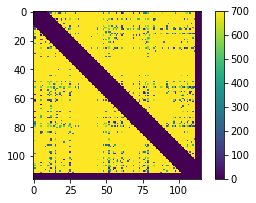

In [278]:
plt.imshow(x)
plt.colorbar()

In [272]:
index_to_three(10)

'MET'

In [274]:
from Bio.PDB.Polypeptide import d3_to_index

In [254]:
(gamma_1[:,:,1] -x)[19,93]

394.0

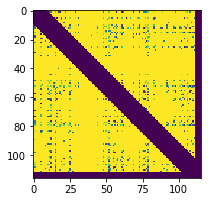

In [225]:
plt.imshow(gamma_1[:,:,1])

In [281]:
(gamma_1[:,:,1] -x).min()

0.0

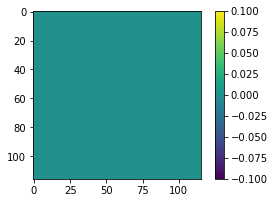

In [279]:
plt.imshow(gamma_1[:,:,1] -x)
plt.colorbar()

In [226]:
print(abs(gamma_1[:,:,1] - gamma_1[:,:,1].T).sum())

0.0


In [227]:
gamma_1[:,:,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [113]:
table = np.zeros((400,400))
for i, line in b.query("Direction=='anti'").iterrows():
    x = line["Res1"]
    y = line["Res2"]
    table[x][y] += line["Protein"]
    table[y][x] += line["Protein"]

In [109]:
plt.rcParams['figure.figsize'] = 4*np.array([10,6.180])    #golden ratio

In [134]:
c = table[np.argsort(np.sum(table, axis=1))][:,np.argsort(np.sum(table, axis=1))]

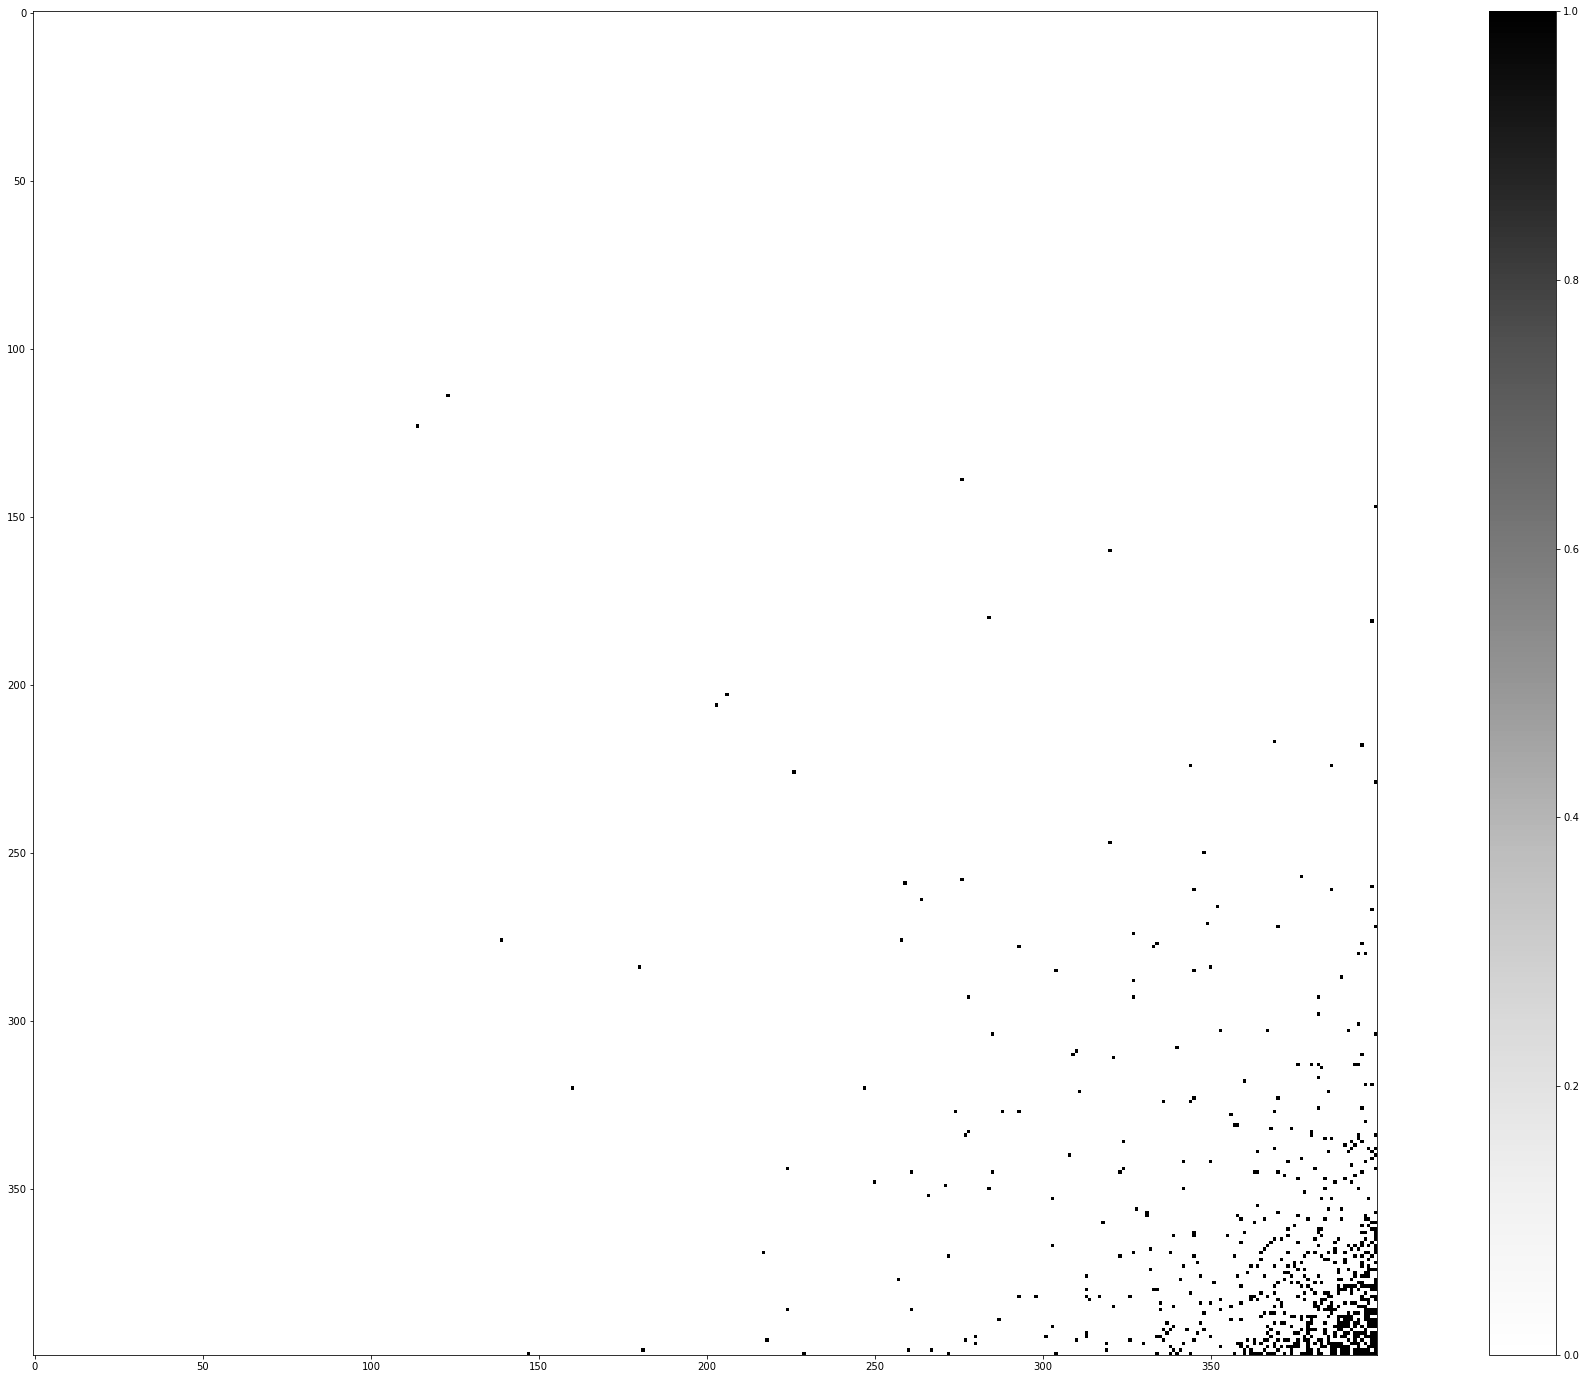

In [137]:
plt.imshow(c>200, cmap="Greys", vmin=0)
plt.colorbar()



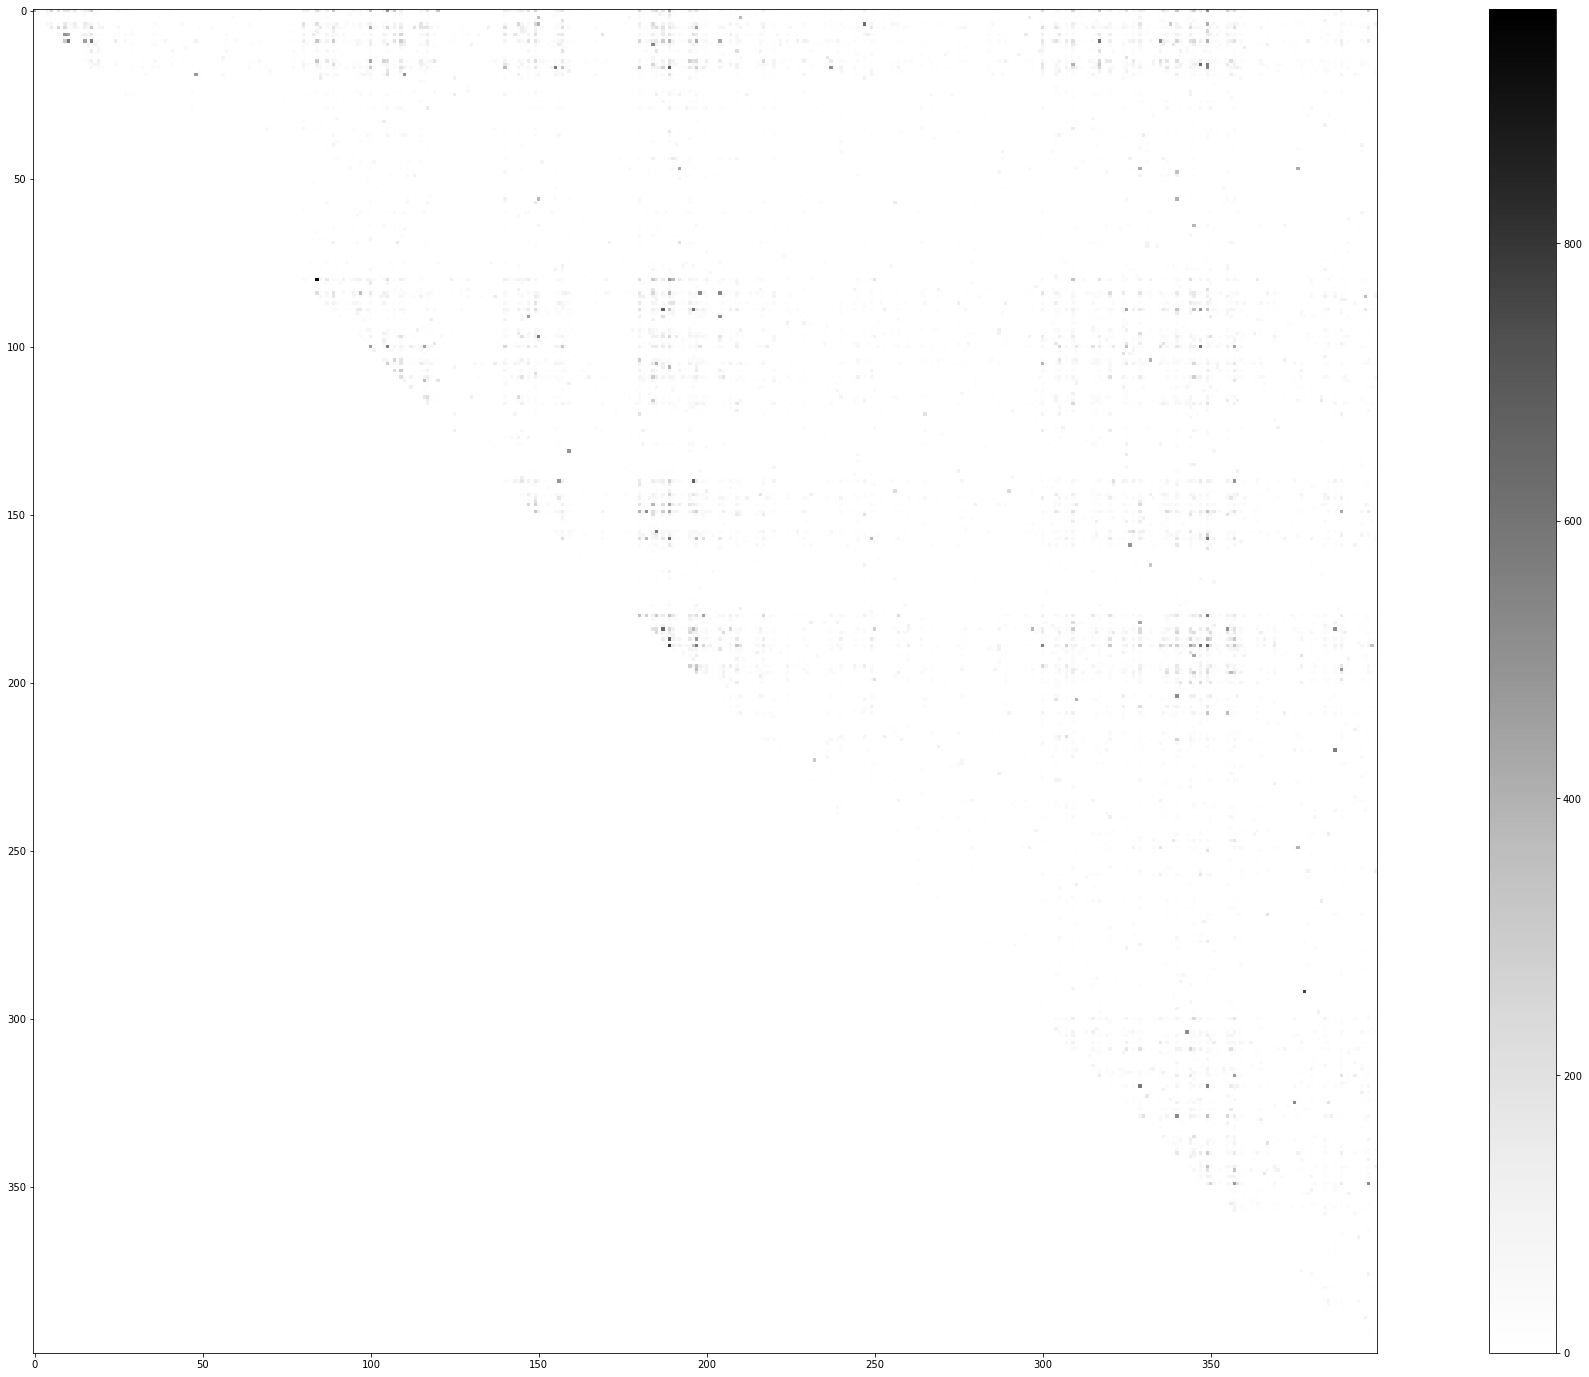

In [110]:
plt.imshow(table, cmap="Greys", vmin=0)
plt.colorbar()

In [90]:
a

,Res1_1,Res1_2,Res2_1,Res2_2,Direction,Protein,Res1,Res2,Res1_letter,Res2_letter
42768,TYR,LEU,GLN,PHE,parallel,1,389,264,TYR_LEU,GLN_PHE
25785,MET,ARG,SER,TRP,parallel,1,214,318,MET_ARG,SER_TRP
25784,MET,ARG,SER,ASP,parallel,1,214,302,MET_ARG,SER_ASP
8684,CYS,SER,ARG,ILE,anti,1,35,287,CYS_SER,ARG_ILE
25780,MET,ARG,PHE,ARG,parallel,1,214,94,MET_ARG,PHE_ARG
...,...,...,...,...,...,...,...,...,...,...
12325,GLY,GLY,ALA,ALA,parallel,780,105,0,GLY_GLY,ALA_ALA
21920,LEU,LEU,LEU,LEU,anti,781,189,189,LEU_LEU,LEU_LEU
28351,PHE,ALA,PHE,PHE,anti,912,80,84,PHE_ALA,PHE_PHE
1,ALA,ALA,ALA,ALA,parallel,1135,0,0,ALA_ALA,ALA_ALA


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121d83ac8>]],
      dtype=object)

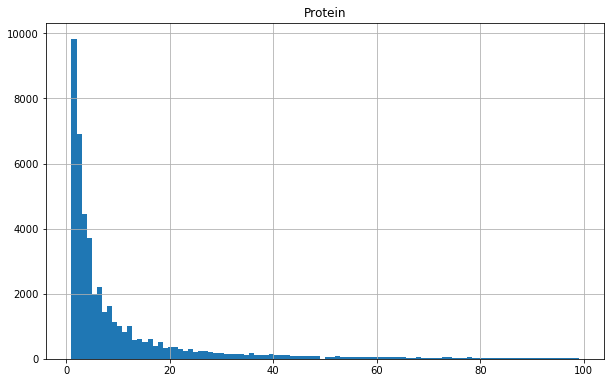

In [72]:
a.query("Protein < 100").hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1031c5668>]],
      dtype=object)

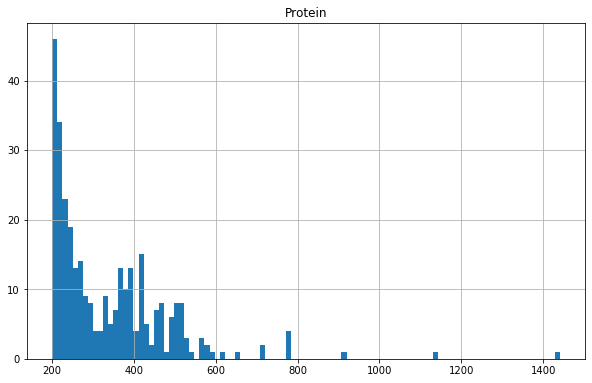

In [75]:
a.query("Protein > 200").hist(bins=100)

In [46]:
data["interaction_index"].value_counts().reset_index()

,index,interaction_index
0,60,56113
1,44,53670
2,42,50351
3,14,30480
4,12,30037
...,...,...
118,99,29
119,27,24
120,32,8
121,31,5


In [43]:
data.shape

(746520, 19)

In [22]:
a

,Res1_1,Res1_2,Res2_1,Res2_2,Direction,rij
42768,TYR,LEU,GLN,PHE,parallel,1
25785,MET,ARG,SER,TRP,parallel,1
25784,MET,ARG,SER,ASP,parallel,1
8684,CYS,SER,ARG,ILE,anti,1
25780,MET,ARG,PHE,ARG,parallel,1
...,...,...,...,...,...,...
12325,GLY,GLY,ALA,ALA,parallel,780
21920,LEU,LEU,LEU,LEU,anti,781
28351,PHE,ALA,PHE,PHE,anti,912
1,ALA,ALA,ALA,ALA,parallel,1135


In [23]:
20*20*20*20*2

320000

In [19]:
tiny.groupby(["Res1_1", "Res1_2", "Res2_1", "Res2_2", "Direction"])["rij"].count().reset_index()

,Res1_1,Res1_2,Res2_1,Res2_2,Direction,rij
0,ALA,VAL,ILE,LEU,anti,1
1,ALA,VAL,ILE,PHE,anti,1
2,ARG,GLY,ASN,SER,parallel,1
3,ILE,ASN,PHE,GLY,anti,1
4,ILE,LEU,VAL,VAL,parallel,1
5,LEU,ALA,VAL,ASN,anti,1
6,LEU,CYS,VAL,ILE,anti,1
7,LEU,LEU,ALA,TYR,anti,1
8,LEU,LEU,THR,LEU,parallel,1
9,SER,GLY,LEU,GLY,parallel,1


In [1]:
from scipy.special import comb

In [7]:
21*(1+21)/2*2

462.0

In [3]:
comb(9, 4)

126.0

In [27]:
data.shape

(746520, 17)

## most common 700 interaction type

In [12]:
b_cutoff_unique = pd.read_csv("/Users/weilu/Research/data/interaction_index_jul12.csv", index_col=0)

In [81]:
pd.read_csv("/Users/weilu/Research/data/interaction_index_jul12.csv", index_col=0)

,Res1,Res2,Direction,Protein,interaction_index
0,107,109,parallel,97,parallel_107_109
1,322,395,parallel,97,parallel_322_395
2,85,150,anti,97,anti_85_150
3,70,331,anti,97,anti_70_331
4,9,189,parallel,97,parallel_9_189
...,...,...,...,...,...
695,325,325,parallel,701,parallel_325_325
696,0,105,parallel,740,parallel_0_105
697,292,378,anti,771,anti_292_378
698,105,105,parallel,895,parallel_105_105


In [34]:
b_cutoff_unique["atom1"] = b_cutoff_unique["Res1"].apply(lambda x: index_to_three(x // 20))
b_cutoff_unique["atom2"] = b_cutoff_unique["Res1"].apply(lambda x: index_to_three(x % 20))
b_cutoff_unique["atom3"] = b_cutoff_unique["Res2"].apply(lambda x: index_to_three(x // 20))
b_cutoff_unique["atom4"] = b_cutoff_unique["Res2"].apply(lambda x: index_to_three(x % 20))

In [40]:
b_cutoff_unique["interaction_type"] = b_cutoff_unique["interaction_index"]

In [42]:
b_cutoff_unique["interaction_index"] = b_cutoff_unique["Direction"] + "_" + b_cutoff_unique["atom1"] + "_" + b_cutoff_unique["atom2"] + "_" + b_cutoff_unique["atom3"] + "_" + b_cutoff_unique["atom4"]

In [47]:
data = pd.concat([b_cutoff_unique, 
                  pd.DataFrame([[-1, -1, "all", -1, "x"]], 
                               columns=b_cutoff_unique.columns[:5])], sort=False).reset_index(drop=True)

In [49]:
data["gamma"] = complete

In [75]:
data["gamma_cutoff"] = gamma_new

In [76]:
t = data.sort_values("gamma_cutoff").head(20)

In [82]:
data

,Res1,Res2,Direction,Protein,interaction_index,atom1,atom2,atom3,atom4,interaction_type,gamma,gamma_cutoff100,gamma_cutoff
0,107,109,parallel,97,parallel_GLY_ILE_GLY_LEU,GLY,ILE,GLY,LEU,parallel_107_109,-2.16218,-0.788643,-0.788643
1,322,395,parallel,97,parallel_THR_ASP_TYR_SER,THR,ASP,TYR,SER,parallel_322_395,-160.33193,-1.075308,-1.075308
2,85,150,anti,97,anti_PHE_GLY_ILE_MET,PHE,GLY,ILE,MET,anti_85_150,-8.37383,-1.026892,-1.026892
3,70,331,anti,97,anti_GLU_MET_THR_ASN,GLU,MET,THR,ASN,anti_70_331,-203.13935,-1.145494,-1.145494
4,9,189,parallel,97,parallel_ALA_LEU_LEU_LEU,ALA,LEU,LEU,LEU,parallel_9_189,-1.22163,-0.396211,-0.396211
...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,0,105,parallel,740,parallel_ALA_ALA_GLY_GLY,ALA,ALA,GLY,GLY,parallel_0_105,-19.11771,-8.416487,-8.416487
697,292,378,anti,771,anti_ARG_PRO_TRP_TRP,ARG,PRO,TRP,TRP,anti_292_378,-1942.56614,-9.171390,-9.171390
698,105,105,parallel,895,parallel_GLY_GLY_GLY_GLY,GLY,GLY,GLY,GLY,parallel_105_105,-55.09020,-11.075072,-11.075072
699,80,84,anti,947,anti_PHE_ALA_PHE_PHE,PHE,ALA,PHE,PHE,anti_80_84,-21.46817,-10.721774,-10.721774


In [77]:
t[["Res1", "Res2", "Direction", "Protein", "interaction_index", "atom1", "atom2", "atom3", "atom4", "gamma_cutoff"]]

,Res1,Res2,Direction,Protein,interaction_index,atom1,atom2,atom3,atom4,gamma_cutoff
698,105,105,parallel,895,parallel_GLY_GLY_GLY_GLY,GLY,GLY,GLY,GLY,-11.075072
699,80,84,anti,947,anti_PHE_ALA_PHE_PHE,PHE,ALA,PHE,PHE,-10.721774
697,292,378,anti,771,anti_ARG_PRO_TRP_TRP,ARG,PRO,TRP,TRP,-9.171390
696,0,105,parallel,740,parallel_ALA_ALA_GLY_GLY,ALA,ALA,GLY,GLY,-8.416487
695,325,325,parallel,701,parallel_THR_GLY_THR_GLY,THR,GLY,THR,GLY,-8.267817
694,145,145,parallel,660,parallel_ILE_GLY_ILE_GLY,ILE,GLY,ILE,GLY,-7.732979
693,0,0,parallel,645,parallel_ALA_ALA_ALA_ALA,ALA,ALA,ALA,ALA,-7.183046
684,220,387,anti,564,anti_ASN_ALA_TYR_ILE,ASN,ALA,TYR,ILE,-6.639020
689,9,10,anti,580,anti_ALA_LEU_ALA_MET,ALA,LEU,ALA,MET,-6.559594
682,105,110,parallel,561,parallel_GLY_GLY_GLY_MET,GLY,GLY,GLY,MET,-6.536741


## set a cutoff, regularization.

In [56]:
def get_filtered_gamma(pre, cutoff, pp):
    # pp = "cath-dataset-nonredundant-S20Clean_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0"
    # pp = "proteins_name_list_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0"

    A_name = pp + "_A"
    B_name = pp + "_B"
    B_filtered_name = pp + "_B_filtered"
    P_name = pp + "_P"
    Gamma_name = pp + "_gamma"
    Gamma_filtered_name = pp + "_gamma_filtered"
    Lamb_name = pp + "_lamb"
    Lamb_filtered_name = pp + "_lamb_filtered"

    A = np.loadtxt(pre+A_name)
    B = np.loadtxt(pre+B_name)
    B_filtered = np.loadtxt(pre+B_filtered_name, dtype=complex, converters={
                               0: lambda s: complex(s.decode().replace('+-', '-'))})
    Gamma = np.loadtxt(pre+Gamma_name)
    Gamma_filtered = np.loadtxt(pre+Gamma_filtered_name, dtype=complex, converters={
                               0: lambda s: complex(s.decode().replace('+-', '-'))})
    Lamb = np.loadtxt(pre+Lamb_name, dtype=complex, converters={
                               0: lambda s: complex(s.decode().replace('+-', '-'))})
    Lamb_filtered = np.loadtxt(pre+Lamb_filtered_name, dtype=complex, converters={
                               0: lambda s: complex(s.decode().replace('+-', '-'))})

    half_B_name = pp + "_half_B"
    half_B = np.loadtxt(pre+half_B_name)
    other_half_B_name = pp + "_other_half_B"
    other_half_B = np.loadtxt(pre+other_half_B_name)
    std_half_B_name = pp + "_std_half_B"
    std_half_B = np.loadtxt(pre+std_half_B_name)


    # pre = "/Users/weilu/Research/server/april_2019/"
    location = pre + f"../../phis/{pp}_phi_decoy_summary.txt"
    A_prime = np.loadtxt(location)

    lamb, P = np.linalg.eig(B)
    lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
    filtered_lamb = np.copy(lamb)
    cutoff_mode = cutoff
    filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                       cutoff_mode, P)
    filtered_gamma = np.dot(filtered_B_inv, A)
    filtered_B = np.linalg.inv(filtered_B_inv)

    return A, A_prime, filtered_gamma, filtered_B_inv

In [69]:
pre = "/Users/weilu/Research/server/jul_week1_2020/head700_gxxxg_shuffle_optimization/optimization_decoyN2000/gammas/"
pp = "filtered_protein_list_phi_gxxxg_v3_well701"
cutoff_i = 100
A, A_prime, filtered_gamma, filtered_B_inv = get_filtered_gamma(pre, cutoff_i, pp)
# c = np.dot(A_prime, original_gamma_deybe)
c = -200
# if args.constant == 0.0:
#     c = np.dot(A_prime, original_gamma)
# else:
#     c = args.constant
# print("A' gamma = constant:", c)
# do(f"echo 'c {c}\n' >> constant_log")
B_inv = filtered_B_inv
lambda_2 = (A_prime.dot(B_inv).dot(A) - c) / (A_prime.dot(B_inv).dot(A_prime))
gamma_new = B_inv.dot(A-A_prime*lambda_2)


In [61]:
g_list = []
for cutoff in [100, 200, 300, 400, 500, 600, 700]:
    g = np.loadtxt(f"/Users/weilu/Research/server/jul_week1_2020/head700_gxxxg_shuffle_optimization/optimization_decoyN2000/saved_gammas/filtered_protein_list_cutoff{cutoff}_impose_Aprime_constraint")
    g_list.append(g)

In [79]:
plt.rcParams['figure.figsize'] = 0.5*np.array([10,6.180])    #golden ratio

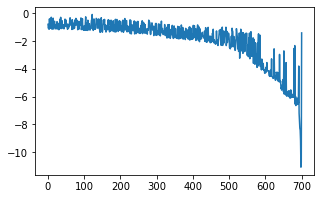

In [168]:
plt.plot(gamma_new)

In [169]:
np.savetxt("/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/gxxxg_701.dat", -gamma_new, fmt="%.3f")

In [ ]:
np.("/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/gxxxg_701.dat", -gamma_new, fmt="%.3f")

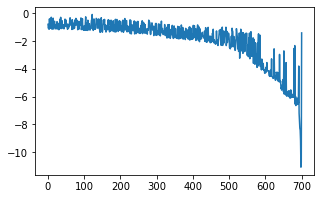

In [80]:
plt.plot(gamma_new)

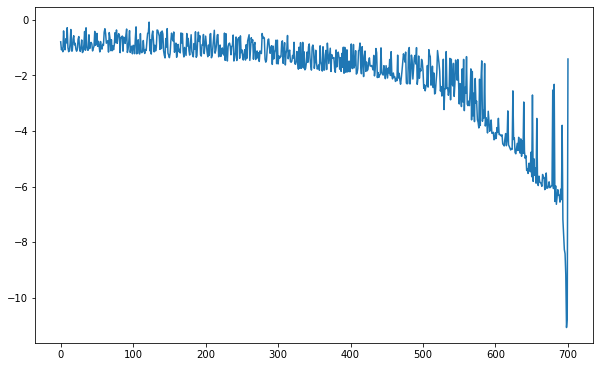

In [68]:
for i, cutoff in enumerate([100]):
    plt.plot(g_list[i])

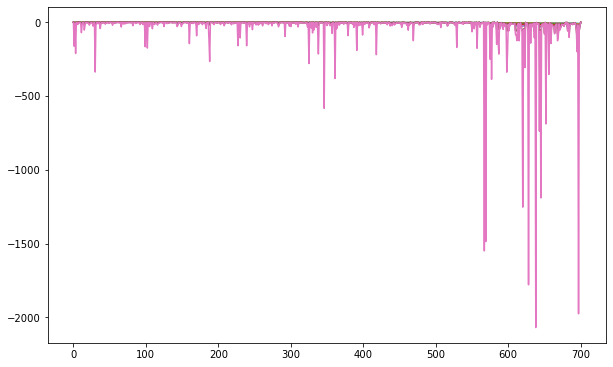

In [62]:
for i, cutoff in enumerate([100, 200, 300, 400, 500, 600, 700]):
    plt.plot(g_list[i])

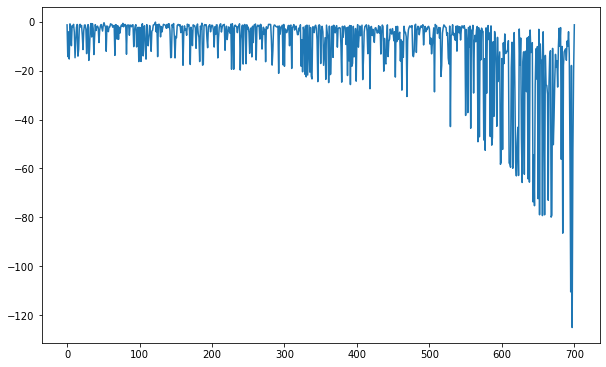

In [60]:
plt.plot(gamma_new)

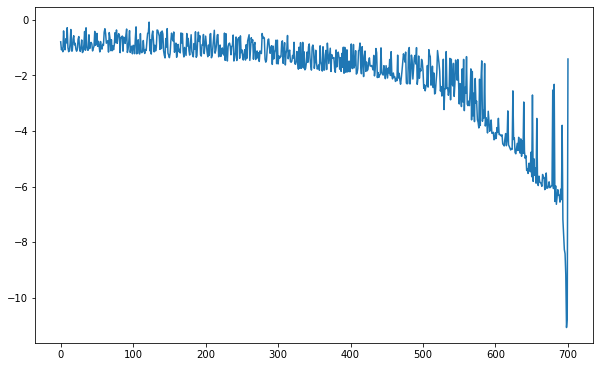

In [58]:
plt.plot(gamma_new)

In [13]:
b_cutoff_unique

,Res1,Res2,Direction,Protein,interaction_index
0,107,109,parallel,97,parallel_107_109
1,322,395,parallel,97,parallel_322_395
2,85,150,anti,97,anti_85_150
3,70,331,anti,97,anti_70_331
4,9,189,parallel,97,parallel_9_189
...,...,...,...,...,...
695,325,325,parallel,701,parallel_325_325
696,0,105,parallel,740,parallel_0_105
697,292,378,anti,771,anti_292_378
698,105,105,parallel,895,parallel_105_105


In [2]:
gamma = np.loadtxt("/Users/weilu/Research/server/jul_week1_2020/head700_gxxxg_shuffle_optimization/optimization_decoyN2000/gammas/top_1600_phi_gxxxg_v3_well701_gamma")

In [4]:
last = np.loadtxt("/Users/weilu/Research/server/jul_week1_2020/head700_gxxxg_shuffle_optimization/optimization_decoyN2000/gammas/last_1600_phi_gxxxg_v3_well701_gamma")

In [6]:
complete = np.loadtxt("/Users/weilu/Research/server/jul_week1_2020/head700_gxxxg_shuffle_optimization/optimization_decoyN2000/gammas/filtered_protein_list_phi_gxxxg_v3_well701_gamma")

In [9]:
compare = np.loadtxt("/Users/weilu/Research/server/jul_week1_2020/decoyN2000_gxxxg_shuffle_optimization/backup/gammas/first_1500_phi_gxxxg_well701_gamma")

## obviously, this is over trained, need regularization.

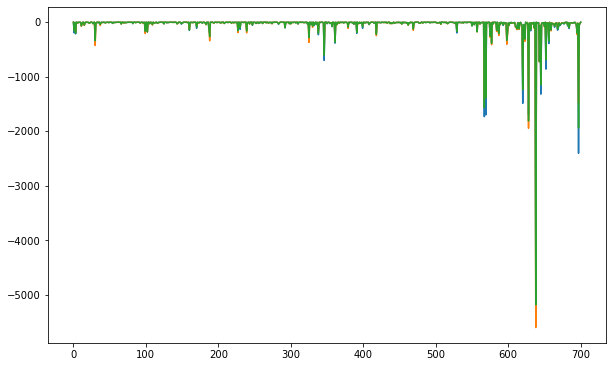

In [8]:
plt.plot(gamma)
plt.plot(last)
plt.plot(complete)

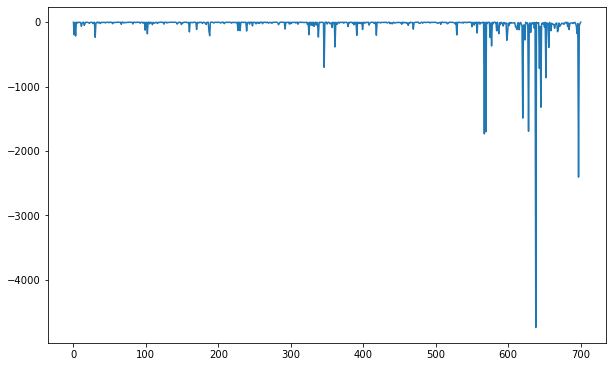

## using Nick's definition, 126 parameters.

In [ ]:
fileLocation = "/Users/weilu/Research/server/jul_week1_2020/decoyN2000_gxxxg_shuffle_optimization/optimization_decoyN2000/gammas/filtered_protein_list_phi_gxxxg_v2_well126_gamma"
gamma = np.loadtxt(fileLocation)
fileLocation = "/Users/weilu/Research/server/jul_week1_2020/gxxxg_shuffle_optimization/optimization_test_2/gammas/first_1600_phi_gxxxg_v2_well126_gamma"
gamma2 = np.loadtxt(fileLocation)



In [23]:
pre = "/Users/weilu/Research/server/jul_week1_2020/decoyN2000_gxxxg_shuffle_optimization/optimization_decoyN2000/gammas/"
pp = "filtered_protein_list_phi_gxxxg_v2_well126"
cutoff_i = 110
A, A_prime, filtered_gamma, filtered_B_inv = get_filtered_gamma(pre, cutoff_i, pp)

c = -50

B_inv = filtered_B_inv
lambda_2 = (A_prime.dot(B_inv).dot(A) - c) / (A_prime.dot(B_inv).dot(A_prime))
gamma_new = B_inv.dot(A-A_prime*lambda_2)

In [24]:
np.dot(gamma_new, A_prime)

-50.000000000000156

In [20]:
g_compare = np.loadtxt("/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/gxxxg.dat")

In [25]:
np.savetxt("/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/gxxxg_2.dat", -gamma_new, fmt="%.3f")

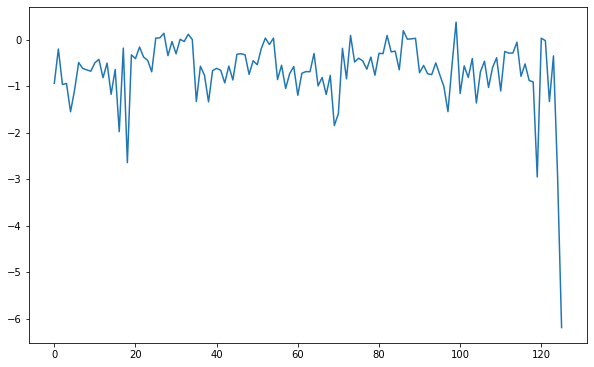

In [8]:
plt.plot(gamma_new)

In [ ]:
g_compare = np.loadtxt("/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/gxxxg.dat")

In [13]:
gamma_new.max()

0.4539776561573122

In [16]:
def plot_list(list_to_plot, text_labels=None, fontsize=20, labelsize=12, aspect=1, labelrotation='horizontal'):
	x = list(range(len(list_to_plot)))
	y = np.array(list_to_plot)
	f = plt.figure()
	ax = f.add_subplot(111, aspect=aspect)
	ax.tick_params(labelsize=labelsize)
	plt.plot(x, y)
    
	if not text_labels == None:
		# #set the bbox for the text. Increase txt_width for wider text.
		# txt_height = 0.04*(plt.ylim()[1] - plt.ylim()[0])
		# txt_width = 0.02*(plt.xlim()[1] - plt.xlim()[0])
		# #Get the corrected text positions, then write the text.
		# text_positions = get_text_positions(text_labels, x, y, txt_width, txt_height)
		# text_plotter(text_labels, x, y, text_positions, txt_width, txt_height)

		# plt.ylim(0,max(text_positions)+2*txt_height)
		for i, txt in enumerate(text_labels):
			ax.annotate(txt, (x[i], y[i]), fontsize=fontsize, rotation=labelrotation)
	plt.show()

In [17]:
b = gamma_new
gammas = sorted(gamma_new)
labels = [label for (gamma,label) in sorted(zip(b,six_letter_code_combinations))]

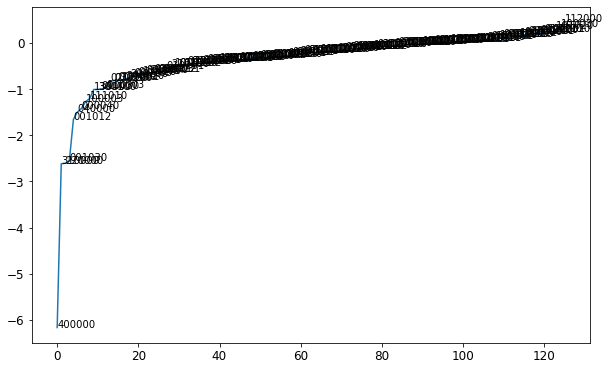

In [18]:
plot_list(gammas, text_labels=labels, fontsize=10, aspect='auto', labelrotation='horizontal')
# plt.ylim([-10,10])

In [130]:
t = np.array(range(10000)).reshape(100,100)
mask = np.zeros((100,100))
mask[10:20,10:20] = 1
mask[10:20,30:40] = 1
mask[30:40,10:20] = 1
mask[30:40,30:40] = 1
tt = t[mask==1].reshape((20,20))